# Project 2 - Case Study of Spam_emails Dectection with SVM
=========

# Use case
You were recently hired in start up company and you were asked to build a system to identify spam emails.

Perform all necessary actions not only limited to,

1). Data Preparation

2). Building word dictionary

3). Feature extraction

4). Training classifiers

5). Testing

6). Performance evaluation using multiple metrics

# Importing Libraries

In [1]:
#Libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string

# Load data

In [2]:
#Read data
df=pd.read_csv('messages.csv')
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


# Inspecting the Dataset

In [3]:
# Shape returns(rows & columns)
df.shape

(2893, 3)

In [4]:
#Features Names
df.columns

Index(['subject', 'message', 'label'], dtype='object')

In [5]:
#Print datatypes
df.dtypes

subject    object
message    object
label       int64
dtype: object

In [6]:
# Duplicates 
df.duplicated().sum()

17

In [7]:
#Removing Duplicates
df.drop_duplicates(inplace=True)
#Print new_shape
df.shape

(2876, 3)

In [8]:
#Missing values
df.isna().sum()

subject    62
message     0
label       0
dtype: int64

In [9]:
#Subject
df['subject'].head()

0              job posting - apple-iss research center
1                                                  NaN
2    query : letter frequencies for text identifica...
3                                                 risk
4                             request book information
Name: subject, dtype: object

In [10]:
df['message']

0       content - length : 3386 apple-iss research cen...
1       lang classification grimes , joseph e . and ba...
2       i am posting this inquiry for sergei atamas ( ...
3       a colleague and i are researching the differin...
4       earlier this morning i was on the phone with a...
                              ...                        
2888    hello thanks for stopping by ! ! we have taken...
2889    the list owner of : " kiddin " has invited you...
2890    judging from the return post , i must have sou...
2891    gotcha ! there are two separate fallacies in t...
2892    hello ! i ' m working on a thesis concerning a...
Name: message, Length: 2876, dtype: object

In [11]:
print('Label:\n', df['label'].value_counts())

Label:
 0    2408
1     468
Name: label, dtype: int64


# Observations:
1). There are 2893-Rows & 3-Columns.

2).There are 17-Duplicated entries and 62-missing values in subject column.

3). The subject & message features are text while label has two values where 1:Spam & 0: not spam.

# Text Pre-processing

In [12]:
# I Drop subject column as it tells the same story with message 
df.drop('subject',axis=1,inplace=True)

#confirm
df.shape

(2876, 2)

In [13]:
#Normalisation
processed = df['message'].str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
                                 'emailaddr')
processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
                                  'httpaddr')
processed = processed.str.replace(r'£|\$', 'moneysymb')    
processed = processed.str.replace(
    r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
    'phonenumbr')    
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

In [14]:
#Removing Punctuations
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [15]:
#Lowercase the text
processed = processed.str.lower()

# Removing stop words

In [16]:
stop_words = nltk.corpus.stopwords.words('english')

In [17]:
processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in set(stop_words))
)

# Stemming

In [18]:
porter = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(
    porter.stem(term) for term in x.split())
)

In [19]:
#Combining all the steps
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )

In [20]:
#sanity check
import re
(processed == df['message'].apply(preprocess_text)).all()

True

In [21]:
example = """  ***** CONGRATlations **** You won 2 tIckETs to Hamilton in 
NYC http://www.hamiltonbroadway.com/J?NaIOl/event   wORtH over $500.00...CALL 
555-477-8914 or send message to: hamilton@freetix.com to get ticket !! !  """

In [22]:
# Test preprocess_text
preprocess_text(example)

'congratl numbr ticket hamilton nyc httpaddr worth moneysymbnumbr call phonenumbr send messag emailaddr get ticket'

# Feature Engineering

# Tokenization

In [23]:
#Creating function
def processed(text):
  #Removing punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)

    #Cleaning the text/Removing stopwords
    clean = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean
# to show the tokenization
df['message'].head().apply(processed)

0    [content, length, 3386, appleiss, research, ce...
1    [lang, classification, grimes, joseph, e, barb...
2    [posting, inquiry, sergei, atamas, satamas, um...
3    [colleague, researching, differing, degrees, r...
4    [earlier, morning, phone, friend, mine, living...
Name: message, dtype: object

# tf-idf

In [24]:
message=df['message']
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(message)

In [25]:
X_ngrams.shape

(2876, 523654)

It looks like the tokenization process extracted 523,654 unigrams and bigrams from the corpus.

# Training and evaluating a model

In [26]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score

# Preliminary Analysis

In [27]:
#Splitting the data into training & Testing
X_train, X_test, y_train, y_test = train_test_split(
    X_ngrams,
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

clf = svm.LinearSVC(loss='hinge')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_test, y_pred)

0.9444444444444444

# Confusion Matrix

In [28]:
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=[['actual', 'actual'], ['spam', 'not spam']],
    columns=[['predicted', 'predicted'], ['spam', 'not spam']]
)

predicted         
                     spam not spam
actual spam           481        1
       not spam         9       85

# Diagnosing the model with learning curves

1). Split the entire dataset k times into a training and validation set

2). For each split, train the model on subsets of the training set, each with fewer training examples

3). Evaluate the model on the validation set and each subset of the training set

4). Average the model performance across the k splits for both training and validation sets

In [29]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
#Computing for learning curve
sample_space = np.linspace(500, len(df['message']) * 0.8, 10, dtype='int')

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=svm.LinearSVC(loss='hinge', C=1e10),
    X=X_ngrams,
    y=df['label'],
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=40),
    scoring='f1',
    n_jobs=-1
)

In [30]:
#Defining function that combines train_score & valid_scores
def make_tidy(sample_space, train_scores, valid_scores):
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='F1 score'
    )

# Plotting Learning Curve 

C:\Users\lklqy\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


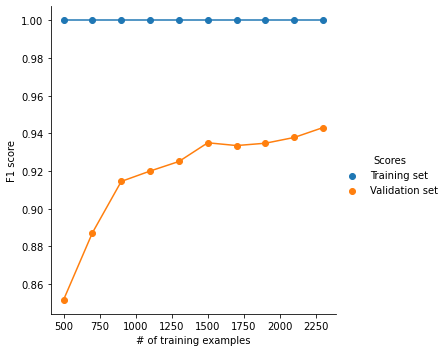

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Plotting the learning curve
g = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

g.map(plt.scatter, '# of training examples', 'F1 score')
g.map(plt.plot, '# of training examples', 'F1 score').add_legend();

# Using nested cross-validation to minimize information leakage

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
#Nested Cross-Validation
param_grid = [{'C': np.logspace(-4, 4, 20)}]

grid_search = GridSearchCV(
    estimator=svm.LinearSVC(loss='hinge'),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

scores = cross_val_score(
    estimator=grid_search,
    X=X_ngrams,
    y=df['label'],
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    scoring='f1',
    n_jobs=-1
)

scores

In [ ]:
scores.mean()

# Top predictors of spam

In [ ]:
#Terms of top predictor of spam
grid_search.fit(X_ngrams, df['label'])
final_clf = svm.LinearSVC(loss='hinge', C=grid_search.best_params_['C'])
final_clf.fit(X_ngrams, df['label']);

# Top 20 n-grams that are most predictive of spam

In [ ]:
# Top 20 n-grams
pd.Series(
    final_clf.coef_.T.ravel(),
    index=vectorizer.get_feature_names()
).sort_values(ascending=False)[:20]

In [ ]:
#Function decides whether string is spam or not
def spam_filter(message):
    if final_clf.predict(vectorizer.transform([preprocess_text(message)])):
        return 'spam'
    else:
        return 'not spam'

In [ ]:
spam_filter('Ohhh, but those are the best kind of foods')

# Concluding Remarks:
We can attempt to boost the classifier's performance but there's simply too many different avenues. However, I'd like to highlight some of the prominent ones.


1. TEXT PRE-PROCESSING :
I handcrafted the regular expressions in this post (by no means an expert!) but I'm certain we can increase their matching performance and efficiency. It may be also be worthwhile using regex to normalize other terms such as dates, times, slang, etc.
I selected the Porter stemmer here but comparing the performance with the Lancaster stemmer would be interesting. However, stemming can be crude and chop off suffixes haphazhardly—a better alternative is lemmatization. For example, the word "worse" reduces to "bad".
We ignored the innate features of each training example such as message length, average word length, distribution of the various forms of punctuation, all-caps frequency, etc. Each of these may enhance the classifier's predictive capacity.


2. FEATURE ENGINEERING :
I discovered Scikit-learn computes term frequency by simply counting each term. Because SMS messages come in a variety of lengths, normalizing the term frequency to the message length is a good idea.
You may have noticed most of the top 20 terms listed above are unigrams. This hints that bigrams aren't as useful in this problem—a bag of words model may be sufficient.


3. MACHINE LEARNING :
Instead of tuning just the classifier's hyperparameters, we can perform a more exhaustive GridSearchCV to compare the use of raw term frequencies instead of tf-idf, or perhaps only tokenizing terms that have a term frequency above/below a threshold. In fact, TfidfVectorizer includes many other knobs to play with. In addition, we can test other classifiers such as Naive Bayes, logistic regression or a neural net. All of these different options can be investigated simultaneously by combining GridSearchCV with Scikit-learn's Pipeline tool.    